In [1]:
import dowhy
from dowhy import CausalModel
import dowhy.datasets

# Avoiding unnecessary log messges and warnings
import logging
logging.getLogger("dowhy").setLevel(logging.WARNING)
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)


In [2]:
# Load some sample data
data = dowhy.datasets.linear_dataset(
    beta=10,
    num_common_causes=5,
    num_instruments=2,
    num_samples=10000,
    treatment_is_binary=True)

In [11]:
data['df']

,Z0,Z1,W0,W1,W2,W3,W4,v0,y
0,0.0,0.017734,1.030380,-2.515016,-0.051024,-1.623820,0.333806,False,-9.031116
1,1.0,0.657184,-0.299027,3.174543,-2.079532,-0.563606,-0.451124,True,16.564211
2,1.0,0.581336,1.451582,-0.689060,-1.592060,0.185073,-0.022402,True,11.306488
3,1.0,0.879285,-0.383479,-0.569459,-0.319219,-0.194082,0.145314,True,5.970043
4,1.0,0.472990,-0.262317,1.122251,-1.347384,-0.184337,1.712459,True,16.415592
...,...,...,...,...,...,...,...,...,...
9995,1.0,0.535487,0.332364,-1.070481,-0.064203,-0.992312,0.654851,True,6.438966
9996,0.0,0.289149,0.055242,-1.452531,-1.039560,0.891441,1.185762,False,-1.138682
9997,1.0,0.692456,-0.213646,0.847031,-1.237253,-0.813552,0.308577,True,10.169155
9998,1.0,0.261192,-2.064495,0.227415,-0.703520,-0.550187,-0.116324,True,0.960683


领域知识编码成一个因果模型，通常用图来表示。因果推理分析的最终结果在很大程度上取决于输入的假设，所以这一步相当重要。为了估计因果效应，大多数常见的问题涉及指定两类变量。

混杂因素。这些是同时引起行动和结果的变量。因此，任何观察到的行动和结果之间的相关性可能仅仅是由于混杂变量造成的，而不是由于从行动到结果的任何因果关系。

工具性变量。这些是导致行动的特殊变量，但不直接影响结果。此外，它们不受任何影响结果的变量的影响。如果使用方法正确，工具性变量可以帮助减少偏见。

In [7]:
# I. Create a causal model from the data and domain knowledge.
model = CausalModel(
    data=data["df"],
    treatment=data["treatment_name"],
    outcome=data["outcome_name"],
    common_causes=data["common_causes_names"],
    intrumental_variables=data["instrument_names"])

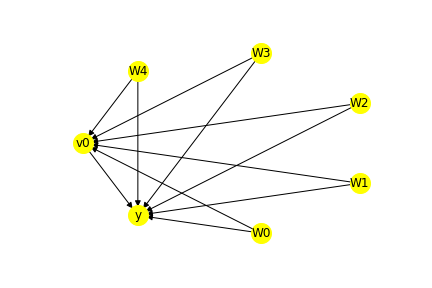

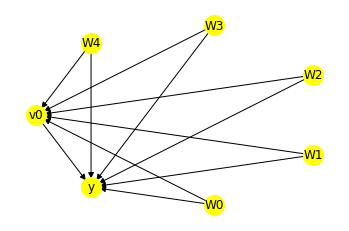

In [8]:
model.view_model(layout="dot")
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

指定一个因果图，描述一个给定数据集的数据生成过程的机制。图中的每个箭头表示一个因果机制："A->B "意味着变量A导致变量B。

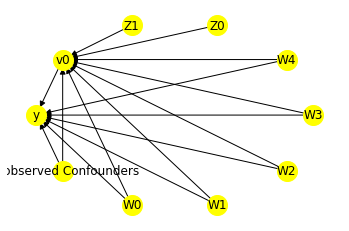

In [9]:
# I. Create a causal model from the data and given graph.
model = CausalModel(
    data=data["df"],
    treatment=data["treatment_name"][0],
    outcome=data["outcome_name"][0],
    graph=data["gml_graph"])
model.view_model(layout="dot")

### 识别

两种提供领域知识的方式（要么通过混杂物和工具变量的命名变量集，要么通过因果图）都对应于一个基本的因果图。给定一个因果图和一个目标量（例如，A对B的影响），识别的过程是检查目标量是否可以在观察到的变量下被估计。重要的是，识别只考虑观察数据中的变量名称；它不需要访问数据本身。与上述两类变量相关，因果推断有两种主要的识别方法。

#### Backdoor criterion 
如果行动A和结果Y的所有共同原因都被观察到，那么Backdoor criterion就意味着因果效应可以通过对所有共同原因的调节来确定。这是一个简化的定义（关于正式的定义，请参考《CausalML》一书的第三章）。

#### Instrumental variable (IV) identification
如果有一个可用的工具变量，那么即使在行动和结果的任何（或没有）共同原因是不可观察的情况下，也可以估计效果。IV识别利用了工具只直接影响行动这一事实，所以工具对结果的影响可以分解成两个连续的部分：工具对行动的影响和行动对治疗的影响。然后，它依靠估计工具对行动和结果的影响来估计行动对结果的影响。对于一个二元工具，效果估计由以下公式给出。

In [10]:
# II. 识别因果效应和返回目标估计值
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W1,W2,W0,W3,W4))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W2,W0,W3,W4,U) = P(y|v0,W1,W2,W0,W3,W4)

### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable found!



### III. 估算

估计步骤涉及建立一个统计估计器，可以计算上一步确定的目标估计值。许多估计器已经被提议用于因果推断。DoWhy实现了一些标准的估计器，而EconML实现了一套机器学习的估计器。

使用DoWhy的倾向分数分层的例子，以及使用EconML的基于机器学习的方法。

In [12]:
# III. Estimate the target estimand using a statistical method.
propensity_strat_estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.dowhy.propensity_score_stratification")

print(propensity_strat_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W1,W2,W0,W3,W4))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W2,W0,W3,W4,U) = P(y|v0,W1,W2,W0,W3,W4)

## Realized estimand
b: y~v0+W1+W2+W0+W3+W4
Target units: ate

## Estimate
Mean value: 10.068678990253472

/Users/han/opt/anaconda3/envs/dissertation38/lib/python3.8/site-packages/dowhy/causal_estimators/propensity_score_stratification_estimator.py:61: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_outcomes.columns = ["_".join(x) for x in weighted_outcomes.columns.ravel()]


In [13]:
import econml
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, 
                                    method_name="backdoor.econml.dml.DML",
                                    method_params={
                                        'init_params': {'model_y':GradientBoostingRegressor(),
                                                        'model_t': GradientBoostingRegressor(),
                                                        'model_final':LassoCV(fit_intercept=False), },
                                        'fit_params': {}
                                     })
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W1,W2,W0,W3,W4))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W2,W0,W3,W4,U) = P(y|v0,W1,W2,W0,W3,W4)

## Realized estimand
b: y~v0+W1+W2+W0+W3+W4 | 
Target units: ate

## Estimate
Mean value: 10.028035771224335
Effect estimates: [10.02803577 10.02803577 10.02803577 ... 10.02803577 10.02803577
 10.02803577]



### IV. Refutation
检查估计值的**稳健性**可能是因果分析中最重要的一步。我们使用步骤1-3得到了一个估计值，但每个步骤都可能做了某些假设，而这些假设可能不真实。在没有适当的验证 "测试 "集的情况下，这一步依靠的是驳斥测试，即利用一个好的估计者的特性来驳斥所获得的估计的正确性。例如，一个反驳测试（placebo_treatment_refuter）检查当行动变量被一个独立于所有其他变量的随机变量取代时，估计器是否返回0的估计值。

In [14]:
# IV. Refute the obtained estimate using multiple robustness checks.
refute_results = model.refute_estimate(identified_estimand, propensity_strat_estimate,
                                       method_name="placebo_treatment_refuter")
print(refute_results)

Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
Index.ravel returnin

### DoWhy+EconML
随着数据的高维化，我们需要专门的方法来处理已知的混杂因素。这里我们使用EconML，它实现了许多最先进的因果估计方法。

这个软件包对所有的技术都有一个通用的API，每一种技术都被实现为一连串的机器学习任务，允许使用任何现有的机器学习软件来解决这些子任务，允许你插入你已经熟悉的ML模型，而不是学习一个新的工具箱。EconML的强大之处在于，你现在可以像运行线性回归或随机森林一样，轻松实现最先进的因果推理。

DoWhy+EconML一起提供了一个最先进的、端到端的因果推断框架，包括最新的因果估计和自动稳健性程序，使回答 "如果 "问题变得更加容易。

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import dowhy.datasets, dowhy.plotter

   Treatment    Outcome        w0         s        w1
0  21.388351  43.323725  3.939286  3.246402 -0.029800
1  29.618260  59.871054  4.850181  9.974925  1.080424
2  15.987297  32.422537 -3.212897  7.887188  0.320338
3  18.951887  37.928772 -3.600419  6.367876  0.332259
4   8.964296  17.672682  1.670250  1.473648 -0.010933


{'df':        Z0        Z1        W0        W1        W2        W3        W4     v0  \
 0     0.0  0.017734  1.030380 -2.515016 -0.051024 -1.623820  0.333806  False   
 1     1.0  0.657184 -0.299027  3.174543 -2.079532 -0.563606 -0.451124   True   
 2     1.0  0.581336  1.451582 -0.689060 -1.592060  0.185073 -0.022402   True   
 3     1.0  0.879285 -0.383479 -0.569459 -0.319219 -0.194082  0.145314   True   
 4     1.0  0.472990 -0.262317  1.122251 -1.347384 -0.184337  1.712459   True   
 ...   ...       ...       ...       ...       ...       ...       ...    ...   
 9995  1.0  0.535487  0.332364 -1.070481 -0.064203 -0.992312  0.654851   True   
 9996  0.0  0.289149  0.055242 -1.452531 -1.039560  0.891441  1.185762  False   
 9997  1.0  0.692456 -0.213646  0.847031 -1.237253 -0.813552  0.308577   True   
 9998  1.0  0.261192 -2.064495  0.227415 -0.703520 -0.550187 -0.116324   True   
 9999  1.0  0.518298  0.512566 -1.532430 -0.895338 -1.248510 -0.905760   True   
 
               y  pr

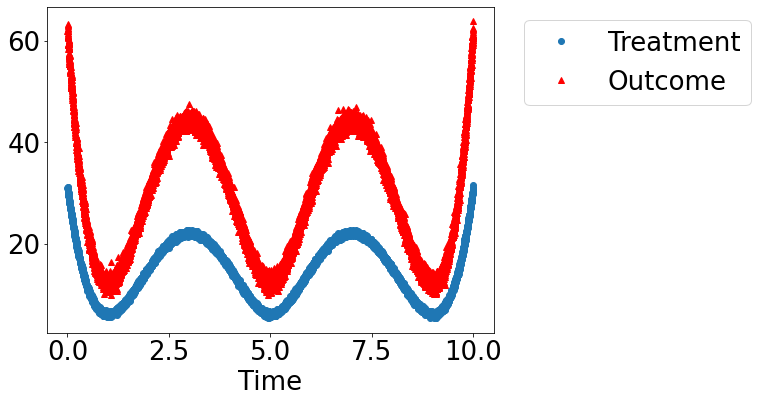

In [28]:
rvar = 1 if np.random.uniform() > 0.2 else 0
is_linear = False # A non-linear dataset. Change to True to see results for a linear dataset.
data_dict = dowhy.datasets.xy_dataset(10000, effect=rvar, 
                                      num_common_causes=2, 
                                      is_linear=is_linear, 
                                      sd_error=0.2) 
df = data_dict['df']                                                                                 
print(df.head())    
dowhy.plotter.plot_treatment_outcome(df[data_dict["treatment_name"]], df[data_dict["outcome_name"]],
                             df[data_dict["time_val"]])
data

使用因果图对数据生成过程的假设进行建模

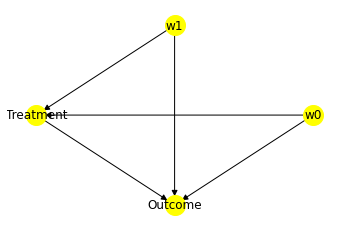

In [21]:
model= CausalModel(                                                                                                                      
        data=df,                                                                                                                         
        treatment=data_dict["treatment_name"],                                                                                           
        outcome=data_dict["outcome_name"],                                                                                               
        common_causes=data_dict["common_causes_names"],                                                                                  
        instruments=data_dict["instrument_names"])                                                                                       
model.view_model(layout="dot")

根据因果模型，确定目标数量的正确估计值

In [22]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                  
────────────(Expectation(Outcome|w0,w1))
d[Treatment]                            
Estimand assumption 1, Unconfoundedness: If U→{Treatment} and U→Outcome then P(Outcome|Treatment,w0,w1,U) = P(Outcome|Treatment,w0,w1)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



估计目标估计值

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                  
────────────(Expectation(Outcome|w0,w1))
d[Treatment]                            
Estimand assumption 1, Unconfoundedness: If U→{Treatment} and U→Outcome then P(Outcome|Treatment,w0,w1,U) = P(Outcome|Treatment,w0,w1)

## Realized estimand
b: Outcome~Treatment+w0+w1
Target units: ate

## Estimate
Mean value: 1.0080600408851224

Causal Estimate is 1.0080600408851224


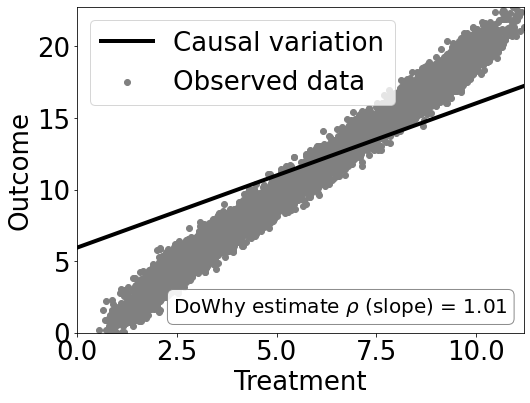

In [23]:
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print(estimate)
print("Causal Estimate is " + str(estimate.value))

# Plot Slope of line between action and outcome = causal effect                                                                                                 
dowhy.plotter.plot_causal_effect(estimate, df[data_dict["treatment_name"]], df[data_dict["outcome_name"]])

对于一个非线性的数据生成过程，线性回归模型无法区分因果效应和观察到的相关关系。

然而，如果DGP是线性的，那么简单的线性回归就会有效。要看到这一点，请尝试在上面的单元格10中设置is_linear=True。

为了给非线性数据（以及有高维混杂因素的数据）建模，我们需要更先进的方法。下面是一个使用EconML的双重机器学习估计器的例子。这个估计器使用基于机器学习的方法，如梯度提升树来学习结果和混杂因素之间的关系，以及治疗和混杂因素之间的关系，然后最后比较结果和治疗之间的残差。

In [24]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=2, include_bias=True)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                  
────────────(Expectation(Outcome|w0,w1))
d[Treatment]                            
Estimand assumption 1, Unconfoundedness: If U→{Treatment} and U→Outcome then P(Outcome|Treatment,w0,w1,U) = P(Outcome|Treatment,w0,w1)

## Realized estimand
b: Outcome~Treatment+w0+w1 | 
Target units: ate

## Estimate
Mean value: 1.0284176941753747
Effect estimates: [1.02841769 1.02841769 1.02841769 ... 1.02841769 1.02841769 1.02841769]



正如你所看到的，DML方法获得了一个更好的估计，即更接近真实的因果效应1。

## Check robustness of the estimate using refutation tests¶

In [25]:
res_random=model.refute_estimate(identified_estimand, dml_estimate, method_name="random_common_cause")
print(res_random)

Refute: Add a Random Common Cause
Estimated effect:1.0284176941753747
New effect:1.033152357337219



In [26]:
res_placebo=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=20)
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:1.0284176941753747
New effect:4.521364165601748e-05
p value:0.48357044417833855

